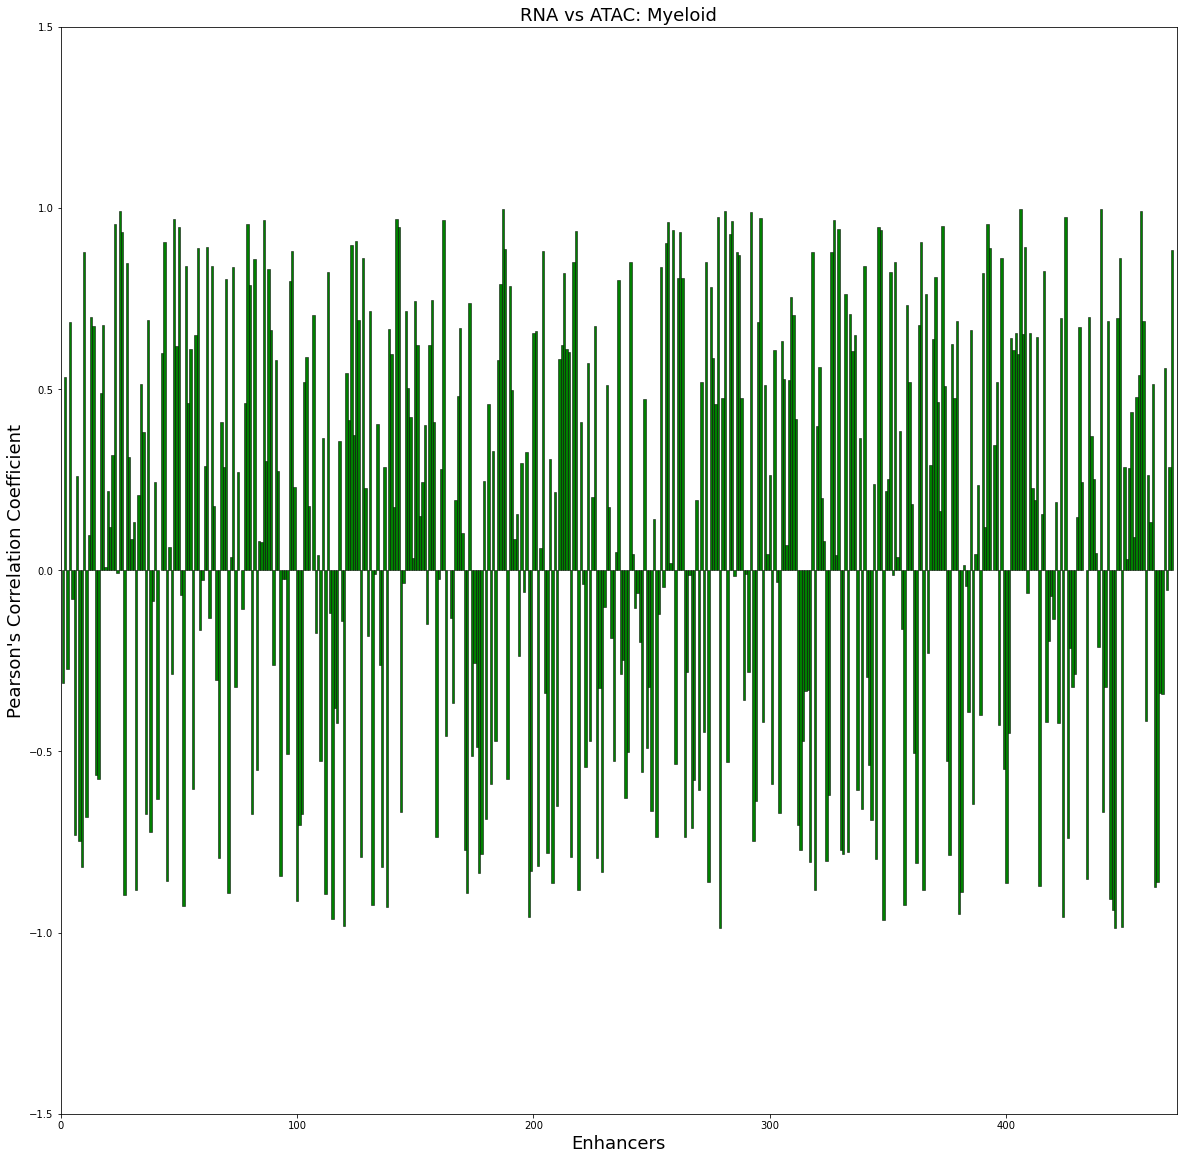

In [63]:
# import data_science as ds 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mplpatches
from scipy import stats
import math

# FUNCTIONS
#reads in all the sample names used as keys in the dictionary
def getFileNames(file, exp):
    samples_list = []
    inFile = open(file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\n')
        name=splitLine[0]
        if exp in name:
            samples_list.append(name)
#         elif exp not in name:
#             print(name)
    inFile.close()
    return samples_list

def norm(sampleDict, exp):
    replCombinedDict = {}
#     print('replicates combined')
    replCombinedDict = combine_replicates(sampleDict, exp)
    normalize_CPKM(replCombinedDict)
    
    return replCombinedDict   

def run_ds_on_exp(samples_dir, rel_path, exp):
#     print('exp: ', exp)
    sampleDict = {}
    samples = getFileNames(samples_dir, exp)
    for sample in samples:
        cts_counts_wlength(rel_path, sample, sampleDict)

    #rename dictionary keys to specify conditions and replicates         
    rename_keys(sampleDict)

    #normalize the data using CPKM
    normDict = norm(sampleDict, exp)
    
    return normDict


#normalizes for sequencing depth CPM counts per million and for enhancer length KB (kilobase)
def normalize_CPKM(exp_dict):
    for name, counts in exp_dict.items():
        count_per_ehancer = [x[0] for x in counts]
        total_counts_per_sample = sum(count_per_ehancer)
        #update key with new values normalized by sequencing depth and by enhancer length
        cpkm_vals = [(tup[0] / (tup[1] * total_counts_per_sample)) * 10**9 for tup in counts]
        log_cpkm_vals = [np.log(x+1) for x in cpkm_vals]
        exp_dict[name] = log_cpkm_vals

#stores cell type specific (cts) counts and length of enhancer as tuples into a dictionary using samples as key
def cts_counts_wlength(rel_path, file, exp_dict):
    counts_endo = []
    counts_fib = []
    counts_mye = []
    inFile = open(rel_path + file, 'r')
    for line in inFile:
        splitLine=line.strip().split('\t')
        start_pos = int(splitLine[1])
        end_pos = int(splitLine[2])
        length = (end_pos - start_pos)+1
        val_endo = int(splitLine[3])
        val_fib = int(splitLine[4])
        val_mye = int(splitLine[5])
        counts_endo.append((val_endo,length))
        counts_fib.append((val_fib,length))
        counts_mye.append((val_mye,length))
    inFile.close()
    sample = file[:7]
#     print(len(counts_endo), len(counts_fib), len(counts_mye))
    exp_dict[sample + '_end'] = counts_endo
    exp_dict[sample + '_fib'] = counts_fib
    exp_dict[sample + '_mye'] = counts_mye
    
def rename(sampleDict, r1, r2, condition):
        #dictionary[new_key] = dictionary.pop(old_key)
        #https://stackoverflow.com/questions/4406501/change-the-name-of-a-key-in-dictionary
        sampleDict['En_'+condition+'_r1'] = sampleDict.pop(r1+'_end')
        sampleDict['Fb_'+condition+'_r1'] = sampleDict.pop(r1+'_fib')
        sampleDict['My_'+condition+'_r1'] = sampleDict.pop(r1+'_mye')
        
        sampleDict['En_'+condition+'_r2'] = sampleDict.pop(r2+'_end')
        sampleDict['Fb_'+condition+'_r2'] = sampleDict.pop(r2+'_fib')
        sampleDict['My_'+condition+'_r2'] = sampleDict.pop(r2+'_mye')
def rename_keys(sampleDict):
        rename(sampleDict, 'Sample1', 'Sample2', 'Sham')
        rename(sampleDict, 'Sample3', 'Sample4', 'TAC')
        rename(sampleDict, 'Sample5', 'Sample6', 'JQ1W')
        rename(sampleDict, 'Sample7', 'Sample8', 'JQ1')
        
def combine(sampleDict, cellType, condition):
    combined = []
    cellType+'_'+condition+'_r1'
    for s1,s2 in zip(sampleDict[cellType+'_'+condition+'_r1'],sampleDict[cellType+'_'+condition+'_r2']):
        combined.append((s1[0]+s2[0], s1[1]))
    return combined
        
def combine_replicates(sampleDict, exp):
    replicateDict = {}  
    replicateDict[exp +'_Endo_Sham'] = combine(sampleDict, 'En', 'Sham')
    replicateDict[exp +'_Fb_Sham'] = combine(sampleDict, 'Fb', 'Sham')
    replicateDict[exp +'_Mye_Sham'] = combine(sampleDict, 'My', 'Sham')
    
    replicateDict[exp +'_Endo_TAC'] = combine(sampleDict, 'En', 'TAC')
    replicateDict[exp +'_Fb_TAC'] = combine(sampleDict, 'Fb', 'TAC')
    replicateDict[exp +'_Mye_TAC'] = combine(sampleDict, 'My', 'TAC')
    
    replicateDict[exp +'_Endo_JQ1W'] = combine(sampleDict, 'En', 'JQ1W')
    replicateDict[exp +'_Fb_JQ1W'] = combine(sampleDict, 'Fb', 'JQ1W')
    replicateDict[exp +'_Mye_JQ1W'] = combine(sampleDict, 'My', 'JQ1W')
    
    replicateDict[exp +'_Endo_JQ1'] = combine(sampleDict, 'En', 'JQ1')
    replicateDict[exp +'_Fb_JQ1'] = combine(sampleDict, 'Fb', 'JQ1')
    replicateDict[exp +'_Mye_JQ1'] = combine(sampleDict, 'My', 'JQ1')
    
    return replicateDict

def merge(expDict, cellType, exp):
    mergeList = []
    for w,x,y,z in zip(expDict[exp+'_'+cellType+'_Sham'], 
                       expDict[exp+'_'+cellType+'_TAC'], 
                       expDict[exp+'_'+cellType+'_JQ1W'], 
                       expDict[exp+'_'+cellType+'_JQ1']):
        mergeList.append((w,x,y,z))
    return mergeList

def plot_cellType(cellType_rna, cellType_atac):
    corr = []
    for r, a in zip(fib_rna, fib_atac):
        corr.append(stats.pearsonr(r, a)[0])
    return corr  
    
#----------------MAIN PROGRAM
rel_path = "../../../data/projects/morin/Counts/cellType_specific_counts/"
#store data in dictionary using key:sample, value: log(count+1) for CPM normalization
#and value: (log(count+1), length) for CPKM normalization


#list of filenames with counts 
samples_dir = "../../../data/projects/morin/cellType_specific_counts.txt"


rnaDict= run_ds_on_exp(samples_dir, rel_path, "RNA")
# print(rnaDict)

#normalize atac data
atacDict= run_ds_on_exp(samples_dir, rel_path, "ATAC")
# print(atacDict)

#merge conditions within celltypes for RNA
endo_rna = merge(rnaDict, 'Endo', 'RNA')
fib_rna = merge(rnaDict, 'Fb', 'RNA')
mye_rna = merge(rnaDict, 'Mye', 'RNA')
 

#merge conditions within celltypes for ATAC
endo_atac = merge(atacDict, 'Endo', 'ATAC')
fib_atac = merge(atacDict, 'Fb', 'ATAC')
mye_atac = merge(atacDict, 'Mye', 'ATAC')
 
# cellType = "Endothelial"      
# corr = plot_cellType(endo_rna, endo_atac)
# cellType = "Fibroblast"
# corr = plot_cellType(fib_rna, fib_atac)

cellType = "Myeloid"
corr = plot_cellType(mye_rna, mye_atac)

bins = [i for i in np.arange(0.5,471,1.0)]  

fig, ax = plt.subplots(figsize=(20, 20))
for i in range(0,len(corr),1):
#         print(i)
#         print("left", bins[i])
#         print('width', bins[i+1]-bins[i])
        bottom=0
        left=bins[i]
        width=bins[i+1]-left
#         print(np.exp(corr[i]))
        height=corr[i]
        rectangle=mplpatches.Rectangle([left,bottom],width,height,
                                   facecolor='g',
                                   edgecolor='black',
                                   linewidth=0.5)
        ax.add_patch(rectangle)
#annotate
# #https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python
# round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))         
# for i in range(1,471,1): 
#     if math.isnan(corr[i-1]) == False:
#         x = round_to_n(corr[i-1], 2)
# #         print(x)
#         pad = 0
#         if x < 0:
#             pad = -.02
#         else:
#             pad = .02
#         ax.text(i, round_to_n(x, 2)+pad, str(x),horizontalalignment='center', verticalalignment='center')


plt.ylim(-1.5,1.5)
plt.xlim(0, 472)
plt.title("RNA vs ATAC: "+cellType, fontsize=18) 
plt.xlabel("Enhancers", fontsize=18)
plt.ylabel("Pearson's Correlation Coefficient", fontsize=18)
fig.show()
# plt.savefig("../../../data/projects/morin/plots/histogram_"+cellType,dpi=600)